# image recognition

following along with [this](https://www.tensorflow.org/tutorials/image_recognition)

In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf

import utils

## usage with python api

first step is cloning [`tensorflow/models`](https://github.com/tensorflow/models).

In [ ]:
!git clone https://github.com/tensorflow/models.git

then run the following to download the `imagenet` data to `/tmp/imagenet` (note: if you want to download it elsewhere, provide the extra flag `--model_dir /path/to/your/imagenet`):

In [2]:
!python models/tutorials/image/imagenet/classify_image.py

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2018-07-10 19:51:26.572800: W tensorflow/core/framework/op_def_util.cc:346] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().
2018-07-10 19:51:26.702923: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-07-10 19:51:26.704228: E tensorflow/stream_executor/cuda/cuda_driver.cc:406] failed call to cuInit: CUDA_ERROR_NO_DEVICE
2018-07-10 19:51:26.704255: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:152] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
giant panda, panda, panda bear, coon bear, 

that's not much -- just a pre-trained model, scored

to get something out of this, let's dig through [the actual `classify_image.py` file contents](https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py)

### `classify_image.py`

the program structure is pretty simple

1. [`maybe_download_and_extract()`](https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py#L170): if the needed model files don't exist, go get them
    1. the download step is a simple `urllib` `get` request followed by decompression of the `gz` archive we download
1. [`run_inference_on_image(image)`](https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py#L130)
    1. [`create_graph()`](https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py#L130): build a graph from a protobuf file (more on that later)
    1. create a `tf.Session`
    1. use the created model to evaluate the `softmax` `logits` for the provided image
    1. map the `logits` to human-readable image lable terms
    1. print the results to the screen

#### `maybe_download_and_extract`

I don't really have anything to add here *except* that if this is not in a shared location this will be wasteful and if it is in a shared location (with multiple ownership) it will be tricky until permissions are set appropriately

#### `run_inference_on_image`

##### `create_graph`

this is the one I'm most interested in. we use `tfGraphDef.ParseFromString` to read the file `classify_image_graph_def.pb` -- this is one of the items we download and extract in `maybe_download_and_extract`.

assuming we downloaded and extracted to the default directory `/tmp/imagenet`, the protobuf file is `/tmp/imagenet/classify_image_graph_def.pb`

In [4]:
with tf.gfile.FastGFile('/tmp/imagenet/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

that's pretty quick! let's inspect it via the `utils` tensorboard visualization hack

In [17]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/zlamberty/notebooks/deep_learning_world_tour/tensorflow_tutorial/utils.py'>

In [18]:
utils.show_graph(make_huge=True)

so, in terms of its implementation, it's actually very straight-forward (literally), but each individual major layer is composed of several parallel layers joined together via `concat` operations. that's kind fuckin nuts.

##### the rest of the code

what follows after that is simple stuff:

1. graph the `softmax` tensor off of the constructed graph
    1. done by name using `sess.graph.get_tensor_by_name('softmax:0')`
1. `sess.run` that tensor with a special `feed_dict`
    1. `feed_dict` key is hard-coded for this tensor and has a value `DecodeJpeg/contents:0`; the content actually loaded is a tensor representing the jpeg encoding of an image and has size (see below)

here's the image we score:

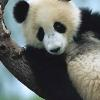

In [19]:
panda_file = '/tmp/imagenet/cropped_panda.jpg'
from IPython.display import Image
Image(filename=panda_file)

in the code, this is represented as follows:

In [29]:
panda_data = tf.gfile.FastGFile(panda_file, 'rb').read()
panda_data[:100]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c'

that single `bytes` object is then passed to the `softmax_tensor` as `'DecodeJpeg/contents:0'`.

as you can see from the graph image up above, the ultimate input is this jpeg bytestring, and the ultimate output is the value of the tensor `softmax_tensor`. so, not bad

In [33]:
decoded_jpeg = tf.image.decode_jpeg(
    contents=panda_data,
    channels=3
)
decoded_jpeg

<tf.Tensor 'DecodeJpeg_3:0' shape=(?, ?, 3) dtype=uint8>

In [34]:
utils.inspect(decoded_jpeg)

[[[ 73  72  68]
  [ 75  76  71]
  [ 68  68  68]
  ...
  [181 212 233]
  [178 209 230]
  [176 207 228]]

 [[ 94  93  89]
  [ 91  90  86]
  [ 46  46  44]
  ...
  [182 213 234]
  [179 210 231]
  [178 209 230]]

 [[ 77  73  70]
  [ 68  67  63]
  [ 68  68  66]
  ...
  [184 216 237]
  [180 212 233]
  [179 211 232]]

 ...

 [[ 97 141 118]
  [ 98 142 119]
  [100 143 123]
  ...
  [135 128 102]
  [118 111  85]
  [113 106  80]]

 [[ 95 139 114]
  [ 96 140 115]
  [ 97 141 118]
  ...
  [127 120  94]
  [112 105  79]
  [111 104  78]]

 [[ 94 138 113]
  [ 95 139 114]
  [ 96 140 117]
  ...
  [117 110  84]
  [107 100  74]
  [110 103  77]]]


we make an entire set of predictions based off this:

In [90]:
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(
        softmax_tensor,
        {'DecodeJpeg/contents:0': panda_data}
    )
    predictions = np.squeeze(predictions)

In [91]:
predictions

array([1.00967838e-04, 2.50168174e-04, 7.98709152e-05, ...,
       1.00967256e-04, 1.00968216e-04, 1.00968216e-04], dtype=float32)

In [92]:
predictions.shape

(1008,)

not sure what the deal is with those extra 8 elements at the end, they're not right. I also think there is an overall constant at the beginning (the label ids start at 1)

In [93]:
predictions = predictions[1:1001]

so, those predictions correspond to a bunch of labels, and extracting the human-readable names of the labels that we use there is actually probably more than half of the code in `classify_image.py`. let's leverage that and create a dataframe with the human readable names

In [94]:
dfpred = pd.DataFrame({'predictions': predictions})
dfpred.head()

,predictions
0,0.000250
1,0.000080
2,0.000127
3,0.000071
4,0.000073


here's a bunch of bullshit for you to ignore just to get the node lookup object

In [95]:
import sys

mypath = '/home/zlamberty/notebooks/deep_learning_world_tour/tensorflow_tutorial/models/tutorials/image/imagenet/'
if mypath not in sys.path:
    sys.path.insert(0, mypath)

import classify_image as CI

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--model_dir', type=str, default='/tmp/imagenet')
parser.add_argument('--image_file', type=str, default='')
FLAGS, unparsed = parser.parse_known_args()

CI.FLAGS = FLAGS

with tf.Session() as sess:
    node_lookup = CI.NodeLookup()

**warning**: I think these will only be ordered properly in 3.5 and beyond. you may need to go actually pull out the values in order

In [96]:
dfpred.loc[:, 'image_label'] = node_lookup.node_lookup.values()

In [97]:
dfpred = dfpred.sort_values(by='predictions', ascending=False)

In [99]:
dfpred.head(15)

,predictions,image_label
168,0.891074,"giant panda, panda, panda bear, coon bear, Ail..."
74,0.007791,"indri, indris, Indri indri, Indri brevicaudatus"
6,0.002959,"lesser panda, red panda, panda, bear cat, cat ..."
324,0.001466,custard apple
877,0.001174,earthstar
656,0.000866,sea urchin
260,0.000540,forklift
528,0.000518,digital watch
184,0.000480,"gibbon, Hylobates lar"
274,0.000477,go-kart


In [109]:
%matplotlib inline
import seaborn as sns

sns.set()

In [ ]:
dfpred.

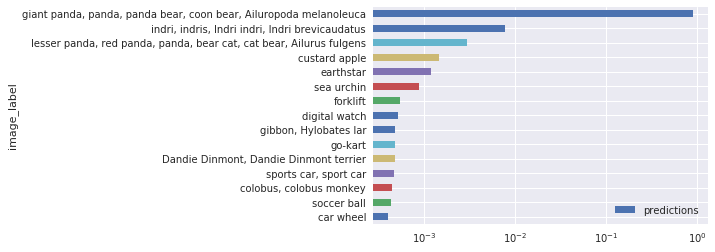

In [116]:
dfpred.head(15) \
    .sort_values(by='predictions') \
    .plot \
    .barh(x='image_label', y='predictions', logx=True)

so, nothing new to show here, but we can do it.

##### clean up

we just downloaded a ton of junk; let's nuke it all

In [117]:
!rm -rf models/

and delete wherever you particularly saved the `imagenet` data:

In [118]:
rm -r /tmp/imagenet/

In [119]:
# !rm -r /home/zlamberty/tmp/imagenet/

## usage with the c++ api

skipping

## resources for learning more

just links to other tutorials

# summary

here we just learn that it is possible to download pre-trained models